<a href="https://colab.research.google.com/github/mrtlckn/IntroToPytorch/blob/main/101_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

 # 1- Load MNIST dataset

In [2]:
# Convert MNIST Image Files into a Tensor of 4-Dimensios(# of images, Height, Widht, Color Channel)
transform = transforms.ToTensor()

In [3]:
# Train Data
train_data = datasets.MNIST(root = '/cnn_data', train=True, download=True, transform=transform)
# Test Data
test_data = datasets.MNIST(root = '/cnn_data', train=False, download=True, transform=transform)



In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

# 2- Convolutional and Pooling Layers

In [6]:
# Create a small batch size for images... let's say 10
train_loader = DataLoader(train_data, batch_size = 10, shuffle= True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle= False)

In [33]:
# Define Our CNN Model
# Describe CNN layer and what it's doing
# This is just an example in the next chapter we'll build out the actual model

conv1 =  nn.Conv2d(1, 6, 3, 1)
conv2 =  nn.Conv2d(6, 16, 3, 1)


In [34]:
# Grab 1 MNIST Record
for i, (X_train, y_train) in enumerate (train_data):
  break

In [35]:
X_train.shape

torch.Size([1, 28, 28])

In [36]:
x = X_train.view(1,1,28,28) # four dimensions. (1 batch, 1 image and size)

In [37]:
# Perform our first convolution
x = F.relu(conv1(x)) # Rectified Linear Unit for out activation function

In [38]:
# 1 single image, 6 is the filters we asked for, 26x26
x.shape

torch.Size([1, 6, 26, 26])

In [39]:
# pass thru pooling layer
x = F.max_pool2d(x, 2, 2) #kernel of 2 and stride of 2

In [40]:
x.shape # 26 / 2 = 13

torch.Size([1, 6, 13, 13])

In [41]:
# Do our second CNN layer
x = F.relu(conv2(x))

In [42]:
x.shape # Again, we didn't set padding so we lose 2 pixels around the outside of the image

torch.Size([1, 16, 11, 11])

In [43]:
# Pooling layer
x = F.max_pool2d(x,2,2)

In [44]:
x.shape # 11 / 2 = 5.5 but we have to round down, because you can't invent data to round up

torch.Size([1, 16, 5, 5])

# 3- Actual Model

In [11]:
# model Class

class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)

    # Fully Connected Layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84,10)

  def forward(self,X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) #2x2 kernel and stride 2

    # Second Pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2) #2x2 kernel and stride 2

    # Re-View to flatten it out
    X = X.view(-1, 16*5*5) # Negative one so that we can vary the batch size


    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X, dim=1)


In [12]:
# Create an Instance of our Model

torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [13]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # Smaller the Learning Rate, longer its gonna take to train.

In [15]:
import time
start_time = time.time()

# Create Variables To Tracks Things
epochs = 5
train_losses = []
test_losses = []

train_correct = []
test_correct = []


# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0


  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+= 1  # start our batches at 1
    y_pred = model(X_train) # get predicted values from the training set. Not flattened 2D
    loss = criterion(y_pred, y_train) # how off are we? Compare the predictions to correct answers in Y_train

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True = 1, False = 0 sum those oup.
    trn_corr += batch_corr # keep track as we go along in training.


    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out some results
    if b%600 == 0: #batch
      print(f'Epochs: {i}, Batch: {b}, Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # Test
  with torch.no_grad(): # No gradient so we don't update our weights and biases with test
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predctions
      tst_corr += (predicted == y_test).sum() # T = 1 F=0 and sum away


  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)



current_time = time.time()
total = current_time- start_time
print(f'Training Took : {total/60} minutes')

Epochs: 0, Batch: 600, Loss: 0.0016589810838922858
Epochs: 0, Batch: 1200, Loss: 0.022251037880778313
Epochs: 0, Batch: 1800, Loss: 0.005315182264894247
Epochs: 0, Batch: 2400, Loss: 0.10110694169998169
Epochs: 0, Batch: 3000, Loss: 0.0011970759369432926
Epochs: 0, Batch: 3600, Loss: 0.002842469373717904
Epochs: 0, Batch: 4200, Loss: 0.3944374918937683
Epochs: 0, Batch: 4800, Loss: 0.009817132726311684
Epochs: 0, Batch: 5400, Loss: 0.0058995941653847694
Epochs: 0, Batch: 6000, Loss: 0.0027530789375305176
Epochs: 1, Batch: 600, Loss: 0.02853192389011383
Epochs: 1, Batch: 1200, Loss: 0.006824986077845097
Epochs: 1, Batch: 1800, Loss: 0.15946803987026215
Epochs: 1, Batch: 2400, Loss: 0.0406726598739624
Epochs: 1, Batch: 3000, Loss: 0.1079246774315834
Epochs: 1, Batch: 3600, Loss: 8.946052548708394e-05
Epochs: 1, Batch: 4200, Loss: 7.343777542700991e-05
Epochs: 1, Batch: 4800, Loss: 0.0003252385649830103
Epochs: 1, Batch: 5400, Loss: 0.01410678494721651
Epochs: 1, Batch: 6000, Loss: 0.0004

# 4- Graph CNN Results

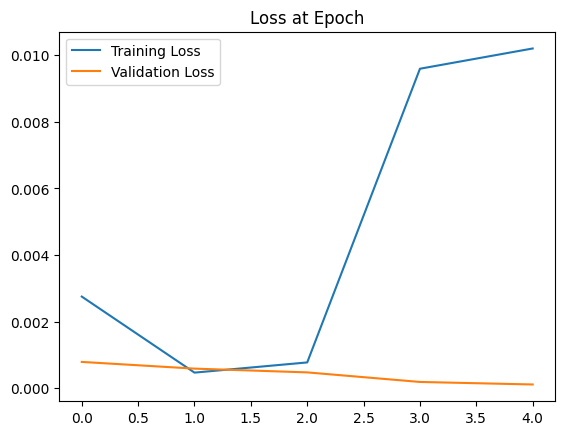

In [18]:
# Graph the loss at epoch
#train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label = "Training Loss")
plt.plot(test_losses, label = "Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

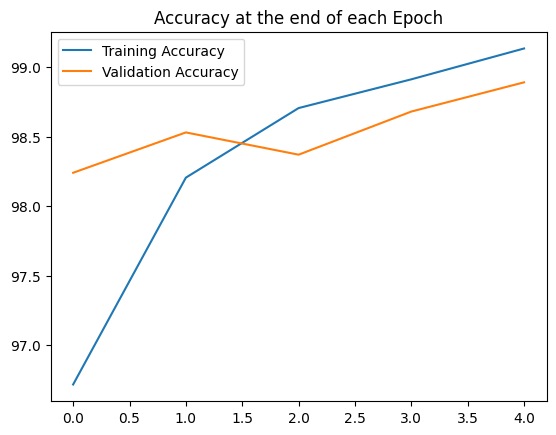

In [19]:
# graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label = "Training Accuracy")
plt.plot([t/100 for t in test_correct], label= "Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [20]:
test_load_everything = DataLoader(test_data, batch_size = 10000, shuffle = False)


In [26]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [28]:
# Did for correct
correct.item() / len(test_data) * 100

98.89